In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from zipfile import ZipFile
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bad-bad-words/bad-words.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv
/kaggle/input/jigsaw-toxic-severity-rating/sample_submission.csv
/kaggle/input/jigsaw-toxic-severity-rating/validation_data.csv
/kaggle/input/jigsaw-toxic-severity-rating/comments_to_score.csv
/kaggle/input/glove-global-vectors-for-word-representation/glove.twitter.27B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.twitter.27B.25d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.twitter.27B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.twitter.27B.100d.txt


In [2]:
sample_data = pd.read_csv('/kaggle/input/jigsaw-toxic-severity-rating/comments_to_score.csv')
sample_data.head()

,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."
2,1139051,I confess to having complete (and apparently b...
3,1434512,"""\n\nFreud's ideas are certainly much discusse..."
4,2084821,It is not just you. This is a laundry list of ...


In [3]:
test = sample_data['text']
test.head()

0    "\n \n\nGjalexei, you asked about whether ther...
1    Looks like be have an abuser , can you please ...
2    I confess to having complete (and apparently b...
3    "\n\nFreud's ideas are certainly much discusse...
4    It is not just you. This is a laundry list of ...
Name: text, dtype: object

In [4]:
lis = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv')
lis2 = pd.read_csv('/kaggle/input/jigsaw-toxic-severity-rating/validation_data.csv')
lis.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
lis['compound'] = lis.sum(axis = 1)
def a(x) :
    if x> 0:
        return 1
    else:
        return 0
lis['y'] = lis['compound'].apply(lambda x: a(x))
lis.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,compound,y
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,0


In [6]:

lis = lis[['comment_text', 'y']]
lis.head()

,comment_text,y
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
less_arr = pd.DataFrame(lis2['less_toxic']).rename(columns = {'less_toxic':'comment_text'}, inplace = False)
more_arr = pd.DataFrame(lis2['more_toxic']).rename(columns = {'more_toxic':'comment_text'}, inplace = False)
more_arr['y'] = 1
less_arr['y'] =  0  
lis  = pd.concat([less_arr, more_arr, lis])
lis.tail()

,comment_text,y
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0
159570,"""\nAnd ... I really don't think you understand...",0


In [8]:
lis.shape

(219787, 2)

In [9]:
contractions_dict = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)
# Expanding Contractions in the reviews
lis['comment_text']= lis['comment_text'].apply(lambda x:expand_contractions(x))

lis.head()

,comment_text,y
0,This article sucks \n\nwoo woo wooooooo,0
1,"""And yes, people should recognize that but the...",0
2,"Western Media?\n\nYup, because every crime in...",0
3,And you removed it! You numbskull! I do not ca...,0
4,smelly vagina \n\nBluerasberry why do not you...,0


In [10]:
test= test.apply(lambda x:expand_contractions(x))

In [11]:
lis['comment_text'] = lis['comment_text'].str.lower()

In [12]:
test = test.str.lower()

In [13]:
import string
lis['comment_text'] = lis['comment_text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))
lis.sample(5)

,comment_text,y
23464,i am glad you are working on a rewrite and i w...,0
19280,\n\nfuck you you fucking piece of shit ass fu...,1
898,i was simply pointing how you contradicted you...,1
2251,\nyeah that paragraph is a mess for starters t...,0
15772,\n\nthe tm topic\nhi irwolfie and welcome to t...,0


In [14]:
test = test.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))

In [15]:
lis['comment_text'] = lis['comment_text'].apply(lambda x: re.sub('\W+',' ', x))
lis.head()

,comment_text,y
0,this article sucks woo woo wooooooo,0
1,and yes people should recognize that but they ...,0
2,western media yup because every crime in the ...,0
3,and you removed it you numbskull i do not care...,0
4,smelly vagina bluerasberry why do not you be ...,0


In [16]:
test = test.apply(lambda x: re.sub('\W+',' ', x))

array([[<AxesSubplot:title={'center':'y'}>]], dtype=object)

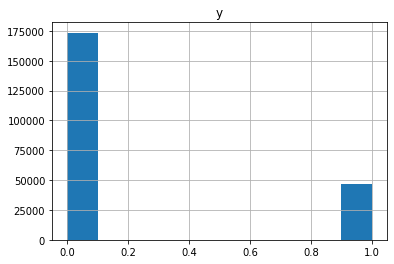

In [17]:
lis[lis['y']>=0].hist()

In [18]:
lis = pd.concat([lis[lis['y'] > 0], lis[lis['y'] == 0].sample(int(len(lis[lis['y'] > 0])*1.5))], axis = 0).sample(frac = 1)

array([[<AxesSubplot:title={'center':'y'}>]], dtype=object)

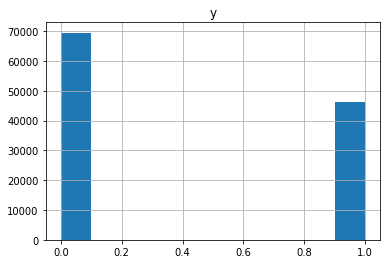

In [19]:
lis[lis['y']>=0].hist()

In [20]:
lis.shape

(115832, 2)

In [21]:
import unidecode
lis['comment_text'] = lis['comment_text'].apply(lambda x: unidecode.unidecode(x))

In [22]:
test = test.apply(lambda x: unidecode.unidecode(x))

In [23]:
submit, texts, outputs = [], [], []
for i in lis.itertuples():
    texts.append(i[1])
    outputs.append(i[-1])
for i in test:
    submit.append(i)

In [24]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words = 250000)
t_samples = 100000
v_samples = 15832
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
submit_sequences = tokenizer.texts_to_sequences(submit)
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))
data = pad_sequences(sequences, maxlen = 1000)
data_submit = pad_sequences(submit_sequences, maxlen = 1000)
outputs = np.asarray(outputs)
print('shape of data tensor', (data.shape, data_submit.shape))
print('shape of output', outputs.shape)


Found 152962 unique tokens
shape of data tensor ((115832, 1000), (7537, 1000))
shape of output (115832,)


In [25]:
indices = np.arange(data.shape[0])
data = data[indices]
labels = outputs[indices]
Xt, Xv = data[:t_samples], data[t_samples: t_samples+v_samples]
yt, yv = outputs[:t_samples], outputs[t_samples: t_samples+v_samples]

In [26]:
f = open(os.path.join('/kaggle/input/glove-global-vectors-for-word-representation', 'glove.twitter.27B.100d.txt'))
embeddings_index = {}
for line in f:
    value = line.split()
    word = value[0]
    coefs = np.asarray(value[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors'%len(embeddings_index))

Found 1193514 word vectors


In [27]:
embedding_dim = 100
embedding_matrix = np.zeros((1193514, embedding_dim))
for word, i in word_index.items():
    if i<200:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.095152  ,  0.37024   ,  0.54290998, ..., -0.51082999,
         0.46877   ,  0.34882   ],
       [ 0.073793  ,  0.22958   ,  0.1619    , ..., -0.57185   ,
         0.56693   , -0.097415  ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [28]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout, GRU
model = Sequential()
model.add(Embedding(1193514, embedding_dim, input_length = 1000))
model.add(GRU(64))
lrelu = lambda x: tf.keras.layers.LeakyReLU( alpha = 0.1)(x)
model.add(Dense(128, activation= lrelu))
model.add(Dropout(0.08))
model.add(Dense(1, activation = 'sigmoid'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

2021-12-19 12:52:14.342943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 12:52:14.436695: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 12:52:14.437434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 12:52:14.438635: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [29]:
history = model.fit(Xt, yt, epochs = 4, batch_size = 32, validation_data = (Xv, yv))


2021-12-19 12:52:18.363125: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/4


2021-12-19 12:52:20.712598: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


3125/3125 [==============================] - 137s 43ms/step - loss: 0.4047 - accuracy: 0.8154 - val_loss: 0.3656 - val_accuracy: 0.8355
Epoch 2/4
3125/3125 [==============================] - 134s 43ms/step - loss: 0.3400 - accuracy: 0.8487 - val_loss: 0.3608 - val_accuracy: 0.8383
Epoch 3/4
3125/3125 [==============================] - 133s 43ms/step - loss: 0.3109 - accuracy: 0.8673 - val_loss: 0.3712 - val_accuracy: 0.8409
Epoch 4/4
3125/3125 [==============================] - 134s 43ms/step - loss: 0.2961 - accuracy: 0.8767 - val_loss: 0.3834 - val_accuracy: 0.8353


In [30]:
predictions = model.predict(data_submit)

In [31]:
sample_data['score'] = predictions
sample_data.head()
del sample_data['text']

In [32]:
sample_data.to_csv('submission.csv', index = False, float_format='%.20f' )
